In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class RemoveFirstFrame(BaseEstimator, TransformerMixin):
    def __init__(self, frame):
        self.frame = frame
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.query(f"Step % {frame} != 1")
def choose_top_rw(data,n=5):
    return data.assign(chosen=pd.DataFrame.rank(data.Rw, method='first')<=n)
def choose_top_vtotal(data,n=5):
    return data.assign(chosen=pd.DataFrame.rank(data.VTotal, method='first')<=n)
def choose_top(data,col="Qw", n=5, ascending=False):
    return data.assign(chosen=pd.DataFrame.rank(data[col], ascending=ascending, method='first')<=n)

In [3]:
# protein_list = ["T0833", "T0815", "T0803", "T0766"]
# name_list = ["Step" , "Chain" , "Shake" , "Chi" , "Rama", "Excluded", "DSSP", "P_AP", "Water" ,"Burial", "Helix", "AMH_Go", "Frag_Mem", "Vec_FM", "Membrane", "SSB" , "Electro.", "QGO" ,"VTotal"]
# all_data_list = []

In [9]:
# protein = "T0833"
# i = 1
# tmp_list = []
# for i in range(1,11):
#     tmp = pd.read_table(f"/Users/weilu/Research/server/awsem_HO/{protein}/AWSEM_energy/run{i}/AWSEM_energy.log", names=name_list)
#     tmp_list.append(tmp)
# awsem = pd.concat(tmp_list)

In [15]:
# gdt = pd.read_table(f"/Users/weilu/Research/server/awsem_HO/{protein}/lowTstructure/GDT.log", names=["gdt"+str(i) for i in range(1,21)], sep="\s+")
# gdt["GDT"] = (gdt["gdt2"] + gdt["gdt4"] + gdt["gdt8"] + gdt["gdt16"])*25
# gdt = gdt.reset_index(drop=True)
rmsd = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar21/{protein}_rmsd.txt", names=["i2", "Rmsd"], sep="\s+")
    qw = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar21/{protein}_qw.txt", names=["i3", "Qw"], sep="\s+")



In [4]:
protein_list = ["T0833", "T0815", "T0803", "T0766"]
name_list = ["Step" , "Chain" , "Shake" , "Chi" , "Rama", "Excluded", "DSSP", "P_AP", "Water" ,"Burial", "Helix", "AMH_Go", "Frag_Mem", "Vec_FM", "Membrane", "SSB" , "Electro.", "QGO" ,"VTotal"]
all_data_list = []
for protein in protein_list:
    tmp_list = []
    for i in range(1,11):
        tmp = pd.read_table(f"/Users/weilu/Research/server/awsem_HO/{protein}/AWSEM_energy/run{i}/AWSEM_energy.log", names=name_list)
        tmp_list.append(tmp)
    awsem = pd.concat(tmp_list)
    rmsd = pd.read_table(f"/Users/weilu/Research/server/awsem_HO/{protein}/totrmsd-angstrom.xvg", names=["i2", "Rmsd"], sep="\s+")
    qw = pd.read_table(f"/Users/weilu/Research/server/awsem_HO/{protein}/Qw.out", names=["i3", "Qw"], sep="\s+")
    rw = pd.read_table(f"/Users/weilu/Research/server/awsem_HO/{protein}/lowTstructure/rwplusScore.short.txt", names=["i", "Rw"], sep="\s+")
    rw = rw.reset_index(drop=True)
    awsem = awsem.reset_index(drop=True).reset_index().drop("Step", axis=1).rename(columns={"index":"Step"})
    gdt = pd.read_table(f"/Users/weilu/Research/server/awsem_HO/{protein}/lowTstructure/GDT.log", names=["gdt"+str(i) for i in range(1,21)], sep="\s+")
    gdt["GDT"] = (gdt["gdt2"] + gdt["gdt4"] + gdt["gdt8"] + gdt["gdt16"])*25
    gdt = gdt.reset_index(drop=True)   
    data = pd.concat([rw, rmsd, qw, gdt["GDT"], awsem], axis=1)
    remove_columns = ['i', "Shake", "Excluded", "Membrane", "Vec_FM", "SSB", "Electro."]
    all_data_list.append(data.drop(remove_columns, axis=1).assign(Name=protein))
data = pd.concat(all_data_list)
data = data.drop_duplicates(subset=['Rw', "VTotal"])

In [5]:
# data["VwithoutGo"] = data["VTotal"] - data["QGO"]
# data["VwithoutGo"] = data["Burial"] + data["Water"] + data["Frag_Mem"]
data["isGood"] = -1
raw_jun08_data = data

In [6]:
raw_jun08_data["VwithoutGo"] = raw_jun08_data["VTotal"] - raw_jun08_data["QGO"]

In [8]:
raw_test_data = pd.read_csv("/Users/weilu/Research/server/casp13/complete_data_mar27.csv", index_col=0)
raw_test_data_bak = raw_test_data

In [10]:
# a = raw_test_data_bak.query("Name not in @protein_list")
# b = raw_jun08_data

In [32]:
protein_list = ['T0833', 'T0815', 'T0766']

In [33]:
a = raw_test_data_bak.query("Name not in @protein_list")
b = raw_jun08_data.query("Name in @protein_list")

In [34]:
raw_test_data = pd.concat([a,b])

In [35]:
raw_test_data.groupby("Name").count()

,AMH_Go,Burial,Chain,Chi,DSSP,Frag_Mem,GDT,Helix,P_AP,QGO,...,Rama,Rmsd,Rw,Step,VTotal,VwithoutGo,Water,i2,i3,isGood
Name,,,,,,,,,,,,,,,,,,,,,
1MBA,0,2000,2000,2000,2000,2000,2000,2000,2000,2000,...,2000,2000,2000,2000,2000,2000,2000,0,0,2000
T0251,0,2000,2000,2000,2000,2000,2000,2000,2000,2000,...,2000,2000,2000,2000,2000,2000,2000,0,0,2000
T0766,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,...,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001
T0784,0,2000,2000,2000,2000,2000,2000,2000,2000,2000,...,2000,2000,2000,2000,2000,2000,2000,0,0,2000
T0792,0,2000,2000,2000,2000,2000,2000,2000,2000,2000,...,2000,2000,2000,2000,2000,2000,2000,0,0,2000
T0803,0,2000,2000,2000,2000,2000,2000,2000,2000,2000,...,2000,2000,2000,2000,2000,2000,2000,0,0,2000
T0815,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,...,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001
T0833,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,...,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001


In [36]:
raw_test_data["Name"].unique()

array(['1MBA', 'T0792', 'T0784', 'T0803', 'T0251', 'T0833', 'T0815',
       'T0766'], dtype=object)

In [37]:
FEATURES = ['Rw',
#      'VTotal',
     'QGO',
     'VwithoutGo',
#      'Burial',
#      'Water',
#      'Rama',
#      'DSSP',
#      'P_AP',
#      'Helix',
#      'Frag_Mem'
               ]
n = 5
def my_transform(data, label, degree, FEATURES=FEATURES):

    # LABEL = "Qw"
    LABEL = label
    PolynomialDegree = degree

    num_attribs = FEATURES
    cat_attribs = [LABEL]
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs))
        ])

    full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    return full_pipeline.fit_transform(data)

def my_transform_predict(data, degree, FEATURES=FEATURES):

    # LABEL = "Qw"
    PolynomialDegree = degree

    num_attribs = FEATURES
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    return num_pipeline.fit_transform(data)

In [38]:
raw_data_T0784 = raw_test_data.groupby("Name").get_group("T0784")
# raw_data_T0792 = raw_test_data.groupby("Name").get_group("T0792")
# raw_data = pd.concat([raw_data_T0784, raw_data_T0792])
# raw_data = raw_data_T0792
# raw_data = raw_test_data.groupby("Name").get_group("1mba")
raw_data = raw_data_T0784

In [39]:
# FEATURES = ["Rw", "VTotal", "QGO"]
# FEATURES = ["Rw", "VTotal", "QGO", "Burial", "Frag_Mem", "Water"]
# FEATURES = list(raw_test_data.columns[2:-3])
def train_and_test(raw_data, label="Qw", degree=1, p=0.1):
    # my_full_pipeline = Pipeline([
    # #         ('removeFirstFrame', RemoveFirstFrame(frame)),
    #         ('featureSelection', full_pipeline)
    # ])

    from sklearn.model_selection import StratifiedShuffleSplit

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=142)
    for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
        strat_train_set = raw_data.iloc[train_index]
        strat_test_set = raw_data.iloc[test_index]
    # strat_test_set[LABEL].value_counts() / len(strat_test_set)
    X_train = my_transform(strat_train_set, label, degree)
    X_test = my_transform(strat_test_set, label, degree)
    train_y = X_train[:,-1]
    train_set = X_train[:,:-1]
    test_y = X_test[:,-1]
    test_set = X_test[:,:-1]
    return (train_set, train_y, test_set, test_y)

In [40]:
label = "isGood"
degree = 1
p = 0.1
train_set, train_y, test_set, test_y = train_and_test(raw_data, label=label, degree=degree)
log_clf = LogisticRegression(random_state=140, penalty='l2')

# log_clf = LogisticRegression(random_state=14, class_weight={0:p, 1:(1-p)}, penalty='l1')
log_clf.fit(train_set, train_y)
y_pred = log_clf.predict(train_set)

In [41]:

# n = 100
n = 5
prediction_list = []
for name, data in raw_test_data.groupby("Name"):
    print(name)
#     X = full_pipeline.fit_transform(data)
    X = my_transform(data, label, degree)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    one = data.assign(prediction=test)
    prediction_list.append(one)
#     prediction_list.append(pd.Series(test))
t = pd.concat(prediction_list)
# t = raw_test_data.assign(prediction=prediction.values)
best_by_prediction = t.groupby("Name").apply(choose_top, n=n, col="prediction").query("chosen==True")

1MBA
T0251
T0766
T0784
T0792
T0803
T0815
T0833


In [42]:
a = best_by_prediction.reset_index(drop=True)[["Name", "QGO", "Qw", "GDT", "Rmsd", "prediction", "Step"]].groupby("Name").apply(lambda x: x.sort_values("prediction", ascending=False))

In [21]:
a.query("Name == 'T0803'")

Name        QGO        Qw      GDT     Rmsd  prediction  Step
Name                                                                    
T0803 25  T0803  50.375613  0.626967  73.5075  5.13183    0.338643     0
      26  T0803  46.163290  0.621708  69.5900  5.72784    0.263991     1
      29  T0803  47.231476  0.657747  70.7100  5.05899    0.261003  1024
      27  T0803  45.717439  0.628857  68.4700  5.50067    0.255502     2
      28  T0803  47.721323  0.643880  68.8425  5.30739    0.243139  1010

In [150]:
a = best_by_prediction.reset_index(drop=True)[["Name", "Qw", "GDT", "prediction", "Step"]].groupby("Name").apply(lambda x: x.sort_values("prediction", ascending=False))

In [30]:
a.reset_index(drop=True).to_csv("/Users/weilu/Desktop/selected_jun09.csv", float_format='%.4f')

In [154]:
a = pd.read_csv("/Users/weilu/Desktop/selected.csv")

In [43]:
for name, one in a.groupby("Name"):
    for i, tmp in one.iterrows():
        print(i, name, tmp["Step"])
        

('1MBA', 0) 1MBA 110
('1MBA', 2) 1MBA 186
('1MBA', 3) 1MBA 189
('1MBA', 4) 1MBA 200
('1MBA', 1) 1MBA 154
('T0251', 5) T0251 606
('T0251', 7) T0251 1086
('T0251', 8) T0251 1214
('T0251', 9) T0251 1643
('T0251', 6) T0251 807
('T0766', 10) T0766 0
('T0766', 12) T0766 827
('T0766', 14) T0766 1764
('T0766', 13) T0766 1763
('T0766', 11) T0766 826
('T0784', 17) T0784 857
('T0784', 15) T0784 831
('T0784', 16) T0784 837
('T0784', 18) T0784 865
('T0784', 19) T0784 1376
('T0792', 21) T0792 178
('T0792', 22) T0792 179
('T0792', 24) T0792 201
('T0792', 23) T0792 184
('T0792', 20) T0792 167
('T0803', 26) T0803 1610
('T0803', 27) T0803 1643
('T0803', 29) T0803 1866
('T0803', 28) T0803 1776
('T0803', 25) T0803 1466
('T0815', 30) T0815 0
('T0815', 34) T0815 190
('T0815', 32) T0815 90
('T0815', 31) T0815 89
('T0815', 33) T0815 182
('T0833', 35) T0833 0
('T0833', 37) T0833 258
('T0833', 36) T0833 256
('T0833', 39) T0833 1219
('T0833', 38) T0833 944


/Users/weilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'Name' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [68]:
best_by_prediction

Rw      GDT  Step       Chain        Chi        Rama  \
Name                                                                         
T0766 827  -22322.338652  91.8975   827  148.186317  30.397764 -495.697677   
      846  -22413.234425  88.8900   846  169.601546  27.520491 -474.202311   
      847  -22458.470655  89.8150   847  165.372415  32.489522 -482.455811   
      1760 -22175.199697  90.5100  1760  195.719946  38.676432 -490.740286   
      1764 -22274.579605  90.2800  1764  180.751936  27.467385 -486.107957   
T0803 619  -21395.073969  72.7600   619    0.000000   0.000000 -427.630839   
      1024 -20985.972609  70.7100  1024    0.000000   0.000000 -439.698792   
      1234 -21170.468921  73.8800  1234    0.000000   0.000000 -421.818954   
      1244 -21392.730493  77.4250  1244    0.000000   0.000000 -435.244266   
      1264 -21468.558905  75.5600  1264    0.000000   0.000000 -428.080396   
T0815 89   -16653.408413  82.3125    89    0.000000   0.000000 -432.482436   
      103  -16746.471052  80.6600   103    0.000000   0.000000 -444.482342   
      171  -16764.211082  82.3100   171    0.000000   0.000000 -444.522847   
      180  -16804.072118  81.6050   180    0.000000   0.000000 -438.495122   
      190  -16640.911653  82.5475   190    0.000000   0.000000 -444.398133   
T0833 0    -21563.739384  47.9175     0    0.000000   0.000000 -573.911419   
      883  -21712.821844  51.1575   883    0.000000   0.000000 -508.106243   
      886  -21716.658486  50.9275   886    0.000000   0.000000 -520.564621   
      1860 -21855.320243  48.8425  1860    0.000000   0.000000 -495.909875   
      1974 -21923.999652  48.1475  1974    0.000000   0.000000 -485.472043   

                 DSSP       P_AP      Water      Burial  ...     Frag_Mem  \
Name                                                     ...                
T0766 827  -51.517541 -27.806797 -54.770629 -112.851662  ...  -626.829802   
      846  -50.993921 -28.180989 -56.889272 -112.488033  ...  -585.292538   
      847  -54.536455 -28.009204 -55.616653 -111.684290  ...  -544.123528   
      1760 -48.053504 -27.447194 -52.426625 -112.116710  ...  -595.312189   
      1764 -45.813249 -26.940633 -51.772265 -112.287121  ...  -660.282464   
T0803 619  -16.987812 -12.450575 -48.000720 -119.278974  ...  -463.198870   
      1024 -18.173751 -12.593026 -48.544432 -117.974957  ...  -454.421375   
      1234 -22.503865 -13.124746 -43.909442 -115.511362  ...  -480.055247   
      1244 -20.190511 -13.733578 -41.585532 -115.243362  ...  -495.048843   
      1264 -21.357357 -13.903564 -40.468150 -114.735162  ...  -436.447353   
T0815 89   -44.042633 -22.703316 -46.862994  -90.416981  ...  -129.849361   
      103  -44.422559 -22.560087 -39.615296  -90.920303  ...  -143.044571   
      171  -44.301685 -22.804151 -38.219620  -92.800484  ...  -135.645293   
      180  -41.882239 -23.181214 -39.770530  -90.869245  ...  -137.295815   
      190  -42.429665 -22.805366 -38.648306  -89.702209  ...  -140.186586   
T0833 0    -84.042793 -38.582839 -43.531493 -118.292683  ...  -189.812043   
      883  -76.669445 -39.021111 -35.514974 -114.374849  ...  -170.553974   
      886  -77.111410 -38.344052 -29.513137 -112.473983  ...  -167.792850   
      1860 -74.665303 -35.459578 -36.785116 -115.867038  ...  -171.569786   
      1974 -69.061187 -34.850567 -38.469119 -116.818484  ...  -161.975352   

                  QGO       VTotal   Name   VwithoutGo isGood  prediction  \
Name                                                                        
T0766 827    0.395986 -1206.804523  T0766 -1207.200509     -1    0.416858   
      846    1.703934 -1124.351890  T0766 -1126.055824     -1    0.332705   
      847    1.987251 -1096.430345  T0766 -1098.417596     -1    0.332628   
      1760   0.563840 -1108.458131  T0766 -1109.021971     -1    0.293780   
      1764   0.615003 -1193.293365  T0766 -1193.908368     -1    0.356741   
T0803 619   51.559764 -1058.402787  T0803 -1109.962551     -1    0.3426

In [44]:
print(*(zip(FEATURES, log_clf.coef_[0])))

('Rw', -0.19232275270600122) ('QGO', -1.6223111058603839) ('VwithoutGo', -0.2896653540669303)


In [16]:
print(*(zip(FEATURES, log_clf.coef_[0])))

('Rw', -0.19232275270600122) ('QGO', -1.6223111058603839) ('VwithoutGo', -0.28966535406693028)


In [132]:
best

AMH_Go      Burial       Chain        Chi       DSSP    Frag_Mem  \
Name                                                                            
1MBA  86        NaN -124.594161  188.990816  34.977292  -0.000000 -287.816488   
      176       NaN -125.739936  182.904382  41.451079  -0.000016 -321.303585   
      180       NaN -123.754336  202.963107  38.336534  -0.000000 -300.792013   
      190       NaN -125.154787  171.621313  35.537802  -0.000000 -313.475180   
      197       NaN -126.716933  181.551899  44.976356  -0.000000 -306.783099   
T0251 14095     NaN  -95.497396    0.000000   0.000000 -10.813573 -170.954771   
      15440     NaN  -93.745282    0.000000   0.000000 -13.525446 -170.812995   
      15441     NaN  -93.925690    0.000000   0.000000 -13.845033 -172.706033   
      15489     NaN  -94.296649    0.000000   0.000000 -13.276053 -175.953233   
      15512     NaN  -90.708217    0.000000   0.000000 -13.899985 -175.534466   
T0766 927       0.0 -112.218615  190.009468  34.477433 -50.674644 -639.375641   
      1048      0.0 -112.100214  182.872866  40.013421 -47.562898 -578.744433   
      1056      0.0 -110.762509  201.212355  29.778304 -51.081013 -546.401122   
      1068      0.0 -112.473271  166.387738  37.859317 -54.232118 -539.518479   
      1073      0.0 -112.272586  178.433270  29.521626 -52.162781 -569.759528   
T0784 8851      NaN -132.585918  199.884006  36.975969 -65.359975 -462.829356   
      8873      NaN -133.897103  230.500793  34.177590 -66.897045 -436.345074   
      8996      NaN -133.680456  228.390961  40.199082 -64.788435 -432.592617   
      9399      NaN -129.307701  207.712550  32.439105 -65.477358 -431.025813   
      9587      NaN -131.612117  195.541887  36.532679 -65.840927 -476.981340   
T0792 2152      NaN  -65.161215    0.000000   0.000000 -12.352314 -141.972107   
      3229      NaN  -64.693309    0.000000   0.000000 -11.673683 -131.627581   
      3578      NaN  -66.930409    0.000000   0.000000 -12.289700 -140.616311   
      3584      NaN  -66.722787    0.000000   0.000000 -11.326644 -138.951983   
      3585      NaN  -66.029546    0.000000   0.000000  -9.508658 -136.538496   
T0803 296       0.0 -114.191593    0.000000   0.000000 -14.981864 -407.760027   
      321       0.0 -115.302908    0.000000   0.000000 -18.182701 -472.118326   
      322       0.0 -114.323570    0.000000   0.000000 -18.205511 -477.324499   
      324       0.0 -115.039995    0.000000   0.000000 -16.439783 -446.595755   
      332       0.0 -116.041071    0.000000   0.000000 -17.589349 -425.509548   
T0815 90        0.0  -90.406395    0.000000   0.000000 -43.980531 -140.090286   
      102       0.0  -91.204010    0.000000   0.000000 -40.001454 -148.673546   
      182       0.0  -91.130377    0.000000   0.000000 -45.772122 -149.269374   
      198       0.0  -89.875454    0.000000   0.000000 -40.249392 -134.862415   
      463       0.0  -90.976109    0.000000   0.000000 -44.773218 -138.227486   
T0833 439       0.0 -114.963202    0.000000   0.000000 -71.660886 -173.815563   
      874       0.0 -114.372699    0.000000   0.000000 -75.180252 -175.517305   
      930       0.0 -115.680378    0.000000   0.000000 -77.246992 -181.144990   
      931       0.0 -115.068523    0.000000   0.000000 -78.548532 -179.088482   
      1274      0.0 -113.026613    0.000000   0.000000 -66.058760 -176.763182   

                 GDT      Helix   Name       P_AP   ...          Qw  \
Name                                                ...               
1MBA  86     78.7675 -48.899861   1MBA  -6.610606   ...    0.752795   
      176    78.9400 -49.949306   1MBA  -6.830135   ...    0.750668   
      180    80.1375 -55.170120   1MBA  -6.093471   ...    0.779434   
      190    78.7700 -51.940474   1MBA  -6.592100   ...    0.776781   
      197    79.6250 -53.638502   1MBA  -7.731975   ...    0.782962   
T0251 14095  74.3075 -12.627823  T0251 -10.161203   ...    0.683560   
      15440  74.7675 -15.375240  T0251 -12

In [70]:
top_rw

Rw      GDT  Step       Chain        Chi        Rama  \
Name                                                                         
T0766 827  -22322.338652  91.8975   827  148.186317  30.397764 -495.697677   
      846  -22413.234425  88.8900   846  169.601546  27.520491 -474.202311   
      847  -22458.470655  89.8150   847  165.372415  32.489522 -482.455811   
      1448 -22240.125803  90.2775  1448  165.603069  30.767948 -478.413646   
      1764 -22274.579605  90.2800  1764  180.751936  27.467385 -486.107957   
T0803 619  -21395.073969  72.7600   619    0.000000   0.000000 -427.630839   
      663  -21521.178365  73.8800   663    0.000000   0.000000 -435.062685   
      664  -21404.532084  71.2675   664    0.000000   0.000000 -401.090302   
      672  -21427.584804  71.6400   672    0.000000   0.000000 -435.786480   
      1264 -21468.558905  75.5600  1264    0.000000   0.000000 -428.080396   
T0815 115  -16829.025866  76.6500   115    0.000000   0.000000 -447.936013   
      133  -16791.601411  79.9525   133    0.000000   0.000000 -435.471016   
      172  -16791.106390  82.7825   172    0.000000   0.000000 -446.769939   
      180  -16804.072118  81.6050   180    0.000000   0.000000 -438.495122   
      1161 -16793.743748  75.4725  1161    0.000000   0.000000 -435.823647   
T0833 86   -21898.027644  47.2225    86    0.000000   0.000000 -517.275054   
      100  -21784.129108  45.8325   100    0.000000   0.000000 -510.599140   
      159  -21788.042061  45.3700   159    0.000000   0.000000 -496.829642   
      1860 -21855.320243  48.8425  1860    0.000000   0.000000 -495.909875   
      1974 -21923.999652  48.1475  1974    0.000000   0.000000 -485.472043   

                 DSSP       P_AP      Water      Burial      Helix  AMH_Go  \
Name                                                                         
T0766 827  -51.517541 -27.806797 -54.770629 -112.851662 -16.310480     0.0   
      846  -50.993921 -28.180989 -56.889272 -112.488033 -15.130797     0.0   
      847  -54.536455 -28.009204 -55.616653 -111.684290 -19.853591     0.0   
      1448 -54.890097 -26.946502 -55.255491 -114.180322 -19.454772     0.0   
      1764 -45.813249 -26.940633 -51.772265 -112.287121 -18.924000     0.0   
T0803 619  -16.987812 -12.450575 -48.000720 -119.278974 -22.414761     0.0   
      663  -16.885874 -13.523302 -42.979516 -115.499280 -23.296194     0.0   
      664  -16.238543 -11.655694 -48.692383 -117.476644 -19.226192     0.0   
      672  -15.095598 -12.614972 -47.293100 -116.669419 -21.629759     0.0   
      1264 -21.357357 -13.903564 -40.468150 -114.735162 -19.747437     0.0   
T0815 115  -43.857319 -23.107574 -38.978721  -91.492054 -11.470373     0.0   
      133  -38.347302 -20.547253 -41.965710  -90.980438  -9.439298     0.0   
      172  -38.889695 -22.513983 -45.535866  -92.448964 -12.893094     0.0   
      180  -41.882239 -23.181214 -39.770530  -90.869245 -11.888221     0.0   
      1161 -41.811641 -22.012821 -38.274847  -91.210937  -9.133709     0.0   
T0833 86   -77.452651 -36.956199 -30.275890 -116.464378 -13.612988     0.0   
      100  -74.816505 -37.444146 -34.220717 -116.958003 -12.706830     0.0   
      159  -70.681290 -31.035675 -29.369323 -116.164090 -14.542253     0.0   
      1860 -74.665303 -35.459578 -36.785116 -115.867038 -15.504339     0.0   
      1974 -69.061187 -34.850567 -38.469119 -116.818484 -11.500540     0.0   

              Frag_Mem        QGO       VTotal   Name   VwithoutGo  isGood  \
Name                                                                         
T0766 827  -626.829802   0.395986 -1206.804523  T0766 -1207.200509      -1   
      846  -585.292538   1.703934 -1124.351890  T0766 -1126.055824      -1   
      847  -544.123528   1.987251 -1096.430345  T0766 -1098.417596      -1   
      1448 -555.231930   1.774940 -1106.226801  T0766 -1108.001741      -1   
      1764 -660.282464   0.615003 -1193.293365  T0766 -1193.908368      -1   
T0803 619  -463.198870  51.559764 -1058.40

In [45]:
# n = 10
chosen_by_rw = raw_test_data.groupby("Name").apply(choose_top_rw, n)
chosen_by_vtotal = raw_test_data.groupby("Name").apply(choose_top_vtotal, n)
chosen_by_qgo = raw_test_data.groupby("Name").apply(choose_top, n=n, col="QGO", ascending=True)
top_rw = chosen_by_rw.query("chosen==True")
top_vtotal = chosen_by_vtotal.query("chosen==True")
top_qgo = chosen_by_qgo.query("chosen==True")

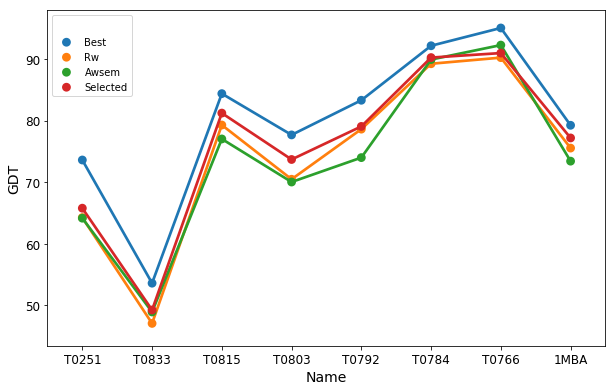

In [46]:
# T0784
label = "GDT"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
f2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
# plt.savefig("/Users/weilu/Desktop/fig6_GDT.png", dpi=300)
# plt.ylim([0.4,1])
final_gdt = final3

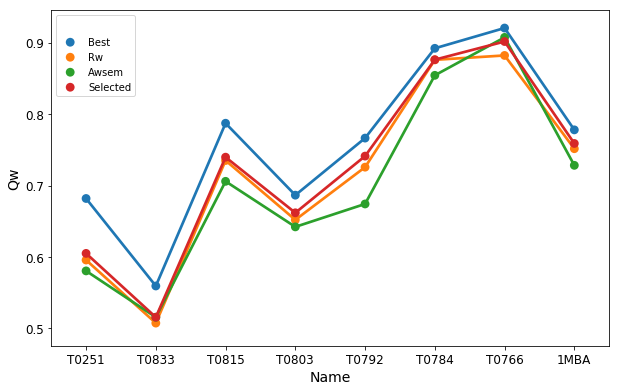

In [47]:
# T0784
label = "Qw"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
# plt.savefig("/Users/weilu/Desktop/fig6_Qw.png", dpi=300)
# plt.ylim([0.4,1])
final_Qw = final3

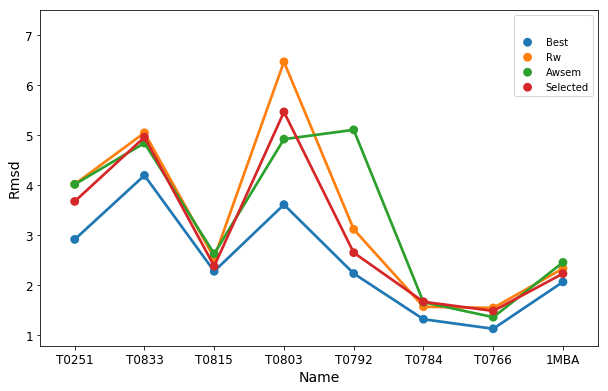

In [48]:
# T0784
label = "Rmsd"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label, ascending=True).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
plt.savefig("/Users/weilu/Desktop/fig6_Rmsd.png", dpi=300)
# plt.ylim([0.4,1])
final_Rmsd = final3

In [49]:
final = pd.concat([final_gdt, final_Qw["Qw"], final_Rmsd["Rmsd"]], axis=1)

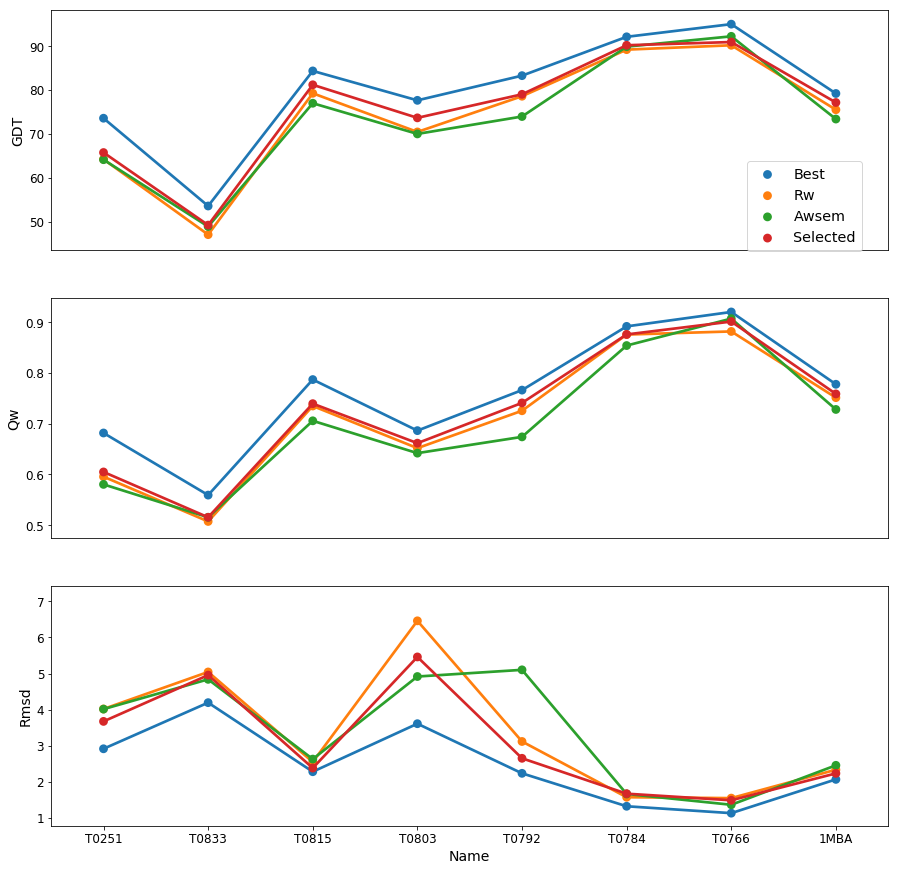

In [50]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15,15))
sns.pointplot("Name", "GDT", data=final, hue=" ", errwidth=0, order=order, ax=ax1)
ax1.legend_.remove()
ax1.get_xaxis().set_visible(False)
sns.pointplot("Name", "Qw", data=final, hue=" ", errwidth=0, order=order, ax=ax2)
ax2.legend_.remove()
ax2.get_xaxis().set_visible(False)
sns.pointplot("Name", "Rmsd", data=final, hue=" ", errwidth=0, order=order, ax=ax3)
plt.legend(loc=9, bbox_to_anchor=(0.9, 2.8), ncol=1, fontsize='x-large')
plt.savefig("/Users/weilu/Desktop/fig6_2.png", dpi=300)

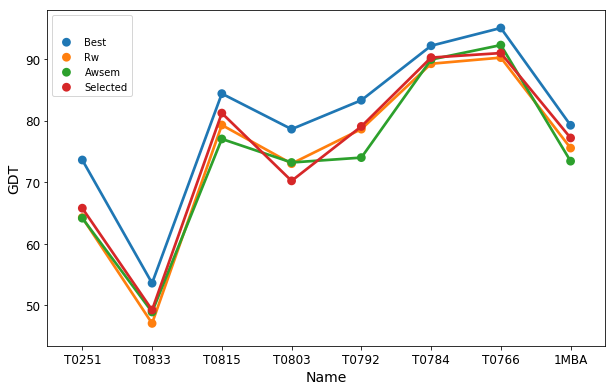

In [25]:
# T0784
label = "GDT"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
f2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
# plt.savefig("/Users/weilu/Desktop/fig6_GDT.png", dpi=300)
# plt.ylim([0.4,1])
final_gdt = final3

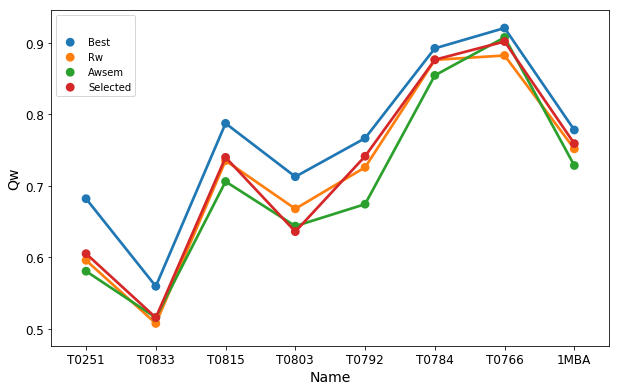

In [26]:
# T0784
label = "Qw"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
# plt.savefig("/Users/weilu/Desktop/fig6_Qw.png", dpi=300)
# plt.ylim([0.4,1])
final_Qw = final3

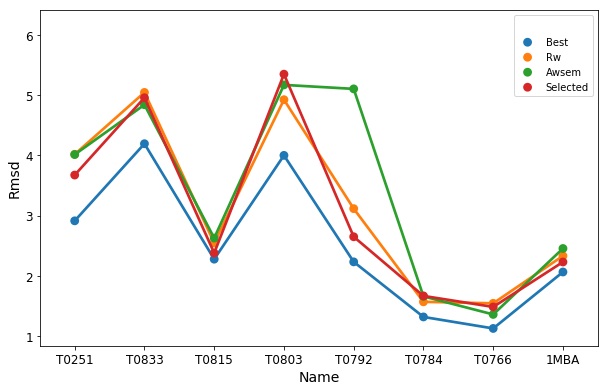

In [27]:
# T0784
label = "Rmsd"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label, ascending=True).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
plt.savefig("/Users/weilu/Desktop/fig6_Rmsd.png", dpi=300)
# plt.ylim([0.4,1])
final_Rmsd = final3

In [28]:
final = pd.concat([final_gdt, final_Qw["Qw"], final_Rmsd["Rmsd"]], axis=1)

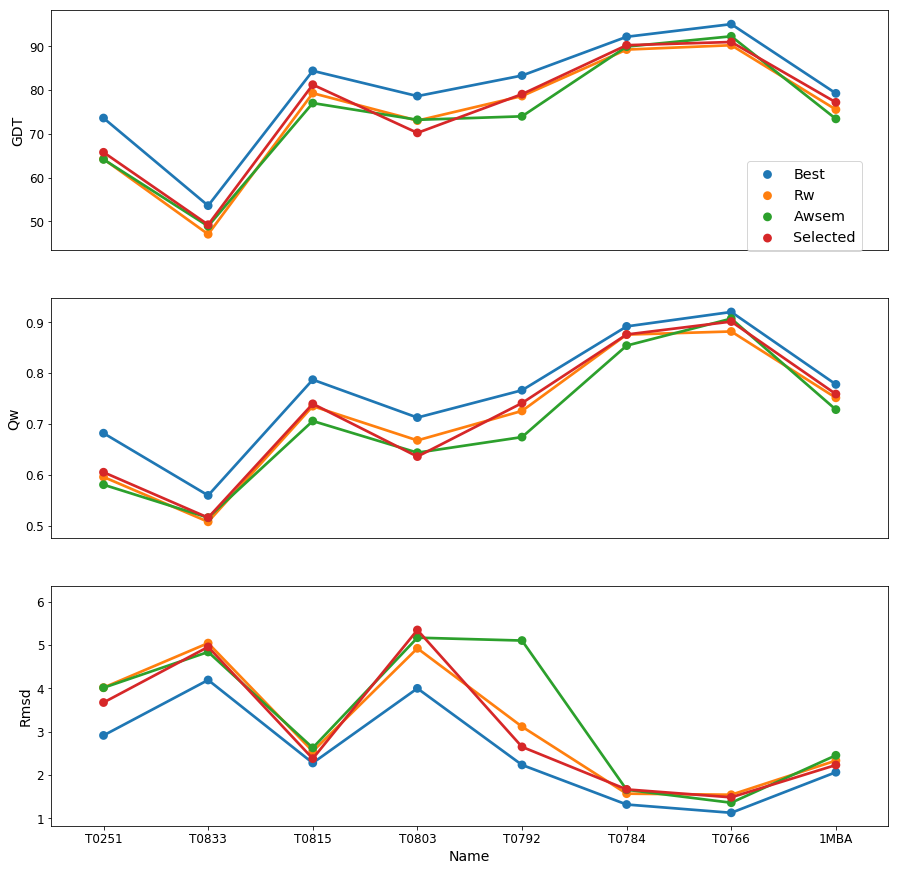

In [29]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15,15))
sns.pointplot("Name", "GDT", data=final, hue=" ", errwidth=0, order=order, ax=ax1)
ax1.legend_.remove()
ax1.get_xaxis().set_visible(False)
sns.pointplot("Name", "Qw", data=final, hue=" ", errwidth=0, order=order, ax=ax2)
ax2.legend_.remove()
ax2.get_xaxis().set_visible(False)
sns.pointplot("Name", "Rmsd", data=final, hue=" ", errwidth=0, order=order, ax=ax3)
plt.legend(loc=9, bbox_to_anchor=(0.9, 2.8), ncol=1, fontsize='x-large')
plt.savefig("/Users/weilu/Desktop/fig6.png", dpi=300)

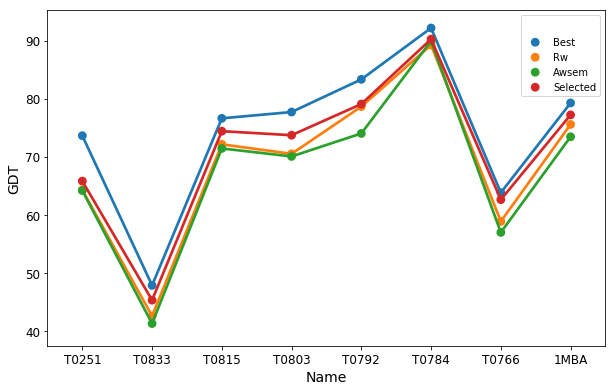

In [22]:
# T0784
label = "GDT"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
plt.savefig("/Users/weilu/Desktop/fig6_GDT.png", dpi=300)
# plt.ylim([0.4,1])
final_gdt = final3

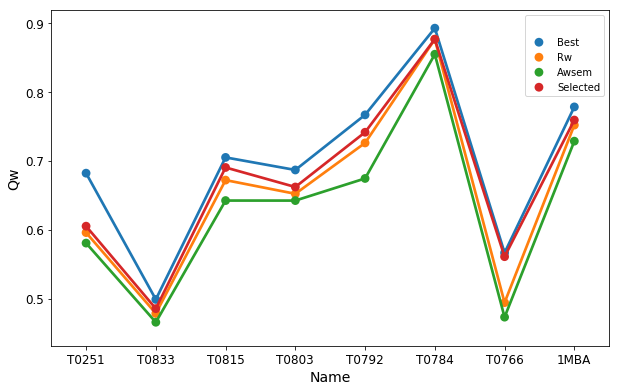

In [23]:
# T0784
label = "Qw"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
plt.savefig("/Users/weilu/Desktop/fig6_Qw.png", dpi=300)
# plt.ylim([0.4,1])
final_Qw = final3

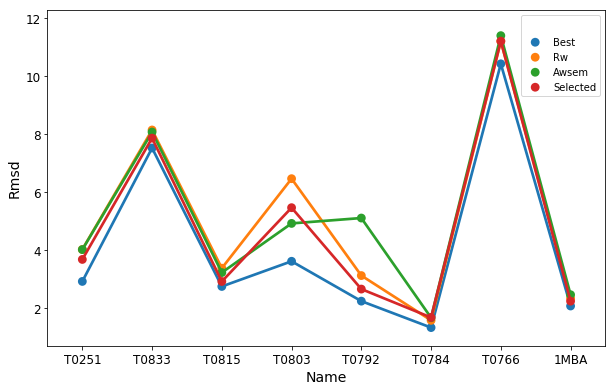

In [24]:
# T0784
label = "Rmsd"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label, ascending=True).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
plt.savefig("/Users/weilu/Desktop/fig6_Rmsd.png", dpi=300)
# plt.ylim([0.4,1])
final_Rmsd = final3

In [32]:
final = pd.concat([final_gdt, final_Qw["Qw"], final_Rmsd["Rmsd"]], axis=1)

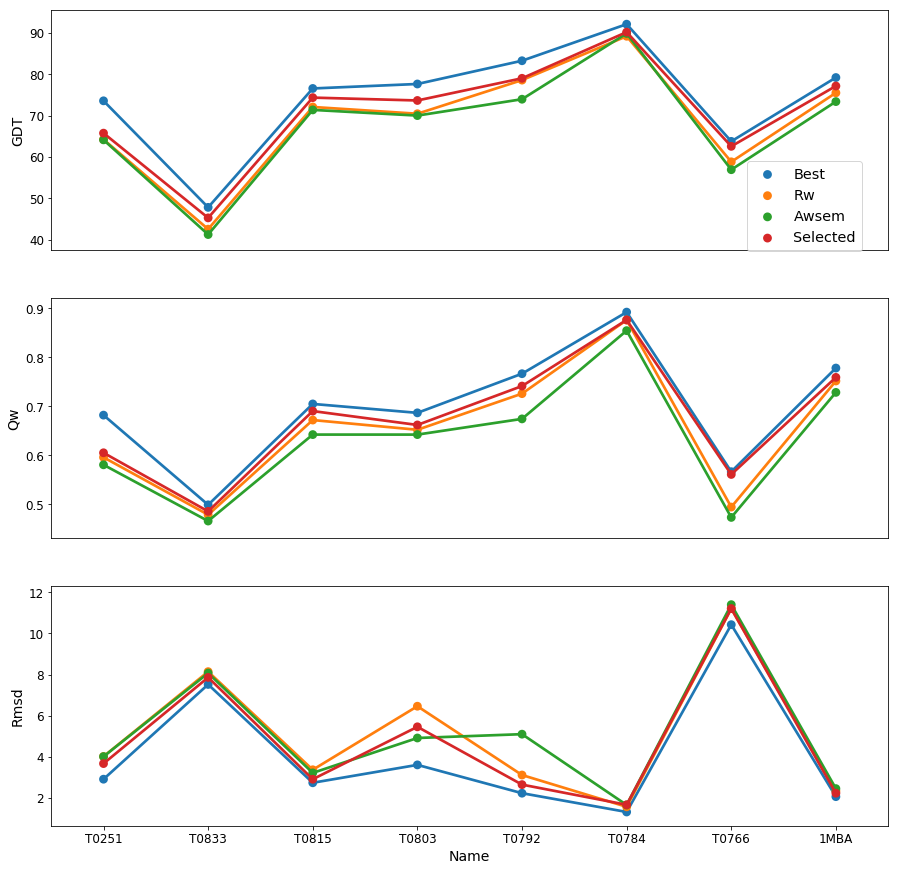

In [64]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15,15))
sns.pointplot("Name", "GDT", data=final, hue=" ", errwidth=0, order=order, ax=ax1)
ax1.legend_.remove()
ax1.get_xaxis().set_visible(False)
sns.pointplot("Name", "Qw", data=final, hue=" ", errwidth=0, order=order, ax=ax2)
ax2.legend_.remove()
ax2.get_xaxis().set_visible(False)
sns.pointplot("Name", "Rmsd", data=final, hue=" ", errwidth=0, order=order, ax=ax3)
plt.legend(loc=9, bbox_to_anchor=(0.9, 2.8), ncol=1, fontsize='x-large')
plt.savefig("/Users/weilu/Desktop/fig6.png", dpi=300)